In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from os.path import join as oj
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from random import randint
from style import *
from captum.attr import *
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF, LatentDirichletAllocation
from transform_wrappers import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier
import pandas as pd
from models import FNN
import attributions
device = 'cuda'

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
out_dir = '/scratch/users/vision/data/cosmo/sim'
dirs = sorted(os.listdir(out_dir))
print(dirs)

['fft', 'fft_unif', 'lda', 'lda_unif', 'nmf', 'nmf_unif', 'nmf_unif2']


In [3]:
results_list = []
for dirname in dirs:
    fname = os.listdir(oj(out_dir, dirname))[0]
    results_list.append(pkl.load(open(oj(out_dir, dirname, fname), 'rb')))
results = pd.DataFrame(results_list)
results.insert(0, 'dir', dirs)
print(results.acc_test)

0    0.95216
1    0.87856
2    0.95888
3    0.67968
4    0.94416
5    0.97840
6    0.97576
Name: acc_test, dtype: float64


In [ ]:
plt.figure(facecolor='white')
# colors = [cb, cr, 'purple', 'green']
R = results.shape[0]
for i in range(R):
    row = results.iloc[i]
    r = row['results']

    accs = []
    ks = sorted(r.keys())
    for k in ks:
        attrs = np.vstack(r[k])
        args = np.argmax(attrs, axis=1)
        num_correct = np.sum(args == row['idx_knockout'])
        accs.append(num_correct / args.size)
        
    plt.title(f'{row.dir} {row.acc_test:.2f}')
    plt.bar(ks, (1-np.array(accs)))
    plt.ylabel('classification err')
    plt.show()

In [171]:
prob = 0.948
num = 1000
print(np.sqrt(prob * (1-prob)) / np.sqrt(num))

0.007021111023192843


In [172]:
# d = scores.size
# idxs = np.zeros(d).astype(bool)
# idxs[idx_zero - window: idx_zero + window + 1] = 1
# plt.plot(np.arange(d)[idxs], scores[idxs], 'o')
# plt.plot(np.arange(d)[~idxs], scores[~idxs], 'o')
# plt.show()

In [248]:
r = results[results.dir == 'nmf_unif2'].iloc[0]
y = r.preds

for key in r.results:
    attrs = np.vstack(r.results[key].values)
    attrs_pos = attrs[y==1]
    attrs_neg = attrs[y==0]

    acc = np.mean(np.argmax(attrs, axis=1) == 12)
    acc_pos = np.mean(np.argmax(attrs_pos, axis=1) == 12)
    print(key, acc, acc_pos)

CD 0.996 1.0
DeepLift 0.996 1.0
IG 0.996 1.0
SHAP 0.996 1.0


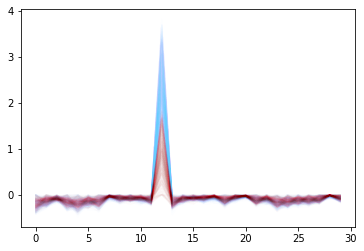

In [209]:
plt.plot(attrs_pos.T, alpha=0.01, color=cb)
plt.plot(attrs_neg.T, alpha=0.01, color=cr)
plt.show()

# check that hyperparams are correct

In [210]:
results.drop('results', axis=1)

,dir,acc_test,data_distr,idx_knockout,labels,lr,n,n_test,net,num_components,num_epochs_train,out_dir,p,pid,preds,transform,window
0,fft,0.95216,NaN,12,NaN,NaN,50000,2000,"FNN(\n (fc1): Linear(in_features=100, out_fea...",NaN,NaN,/scratch/users/vision/data/cosmo/sim,100,66257609305319508671,NaN,irfft,0
1,fft_unif,0.87856,uniform,12,NaN,0.10,50000,500,"FNN(\n (fc1): Linear(in_features=100, out_fea...",30.0,12.0,/scratch/users/vision/data/cosmo/sim/fft_unif,100,86068516496196794951,NaN,fft,0
2,lda,0.95888,NaN,12,NaN,0.01,50000,500,"FNN(\n (fc1): Linear(in_features=100, out_fea...",30.0,12.0,/scratch/users/vision/data/cosmo/sim/lda,100,08722341460397210112,NaN,irfft,0
3,lda_unif,0.67968,uniform,12,NaN,0.01,50000,500,"FNN(\n (fc1): Linear(in_features=100, out_fea...",30.0,12.0,/scratch/users/vision/data/cosmo/sim/lda_unif,100,49892183150043360236,NaN,lda,0
4,nmf,0.94416,NaN,12,NaN,0.01,50000,500,"FNN(\n (fc1): Linear(in_features=100, out_fea...",30.0,12.0,/scratch/users/vision/data/cosmo/sim/nmf2,100,37451272574898306406,NaN,irfft,0
5,nmf_unif,0.97840,uniform,12,NaN,0.01,50000,500,"FNN(\n (fc1): Linear(in_features=100, out_fea...",30.0,12.0,/scratch/users/vision/data/cosmo/sim/nmf_unif,100,07661681622171777799,NaN,nmf,0
6,nmf_unif2,0.97576,uniform,12,"[0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, ...",0.01,50000,500,"FNN(\n (fc1): Linear(in_features=100, out_fea...",30.0,12.0,/scratch/users/vision/data/cosmo/sim/nmf_unif2,100,15333344111662240097,"[1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, ...",nmf,0
